In [1]:
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value= -1)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances


#Cluster Validation technique
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("data.csv")
print(data.shape)
data.head(3)

(11608, 29)


,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for promoting interoperability of EHRs,Hospital overall rating,Hospital overall rating footnote,Mortality national comparison,Mortality national comparison footnote,Safety of care national comparison,Safety of care national comparison footnote,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Year
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,NaN,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,2020
1,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,2020
2,10006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,Yes,Y,2,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,2020


In [3]:
#Checking for null values
data.isnull().sum()

Facility ID                                                          0
Facility Name                                                        0
Address                                                              0
City                                                                 0
State                                                                0
ZIP Code                                                             0
County Name                                                          3
Phone Number                                                         0
Hospital Type                                                        0
Hospital Ownership                                                   0
Emergency Services                                                   0
Meets criteria for promoting interoperability of EHRs                0
Hospital overall rating                                              0
Hospital overall rating footnote                                 11601
Mortal

In [4]:
#Droping the columns whose null value percentage >70
data = data.drop(columns =['Hospital overall rating footnote',
                  'Mortality national comparison footnote',
                 'Safety of care national comparison footnote',
                 'Readmission national comparison footnote',
                 'Patient experience national comparison footnote',
                  'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote',
                 'Efficient use of medical imaging national comparison footnote'], axis = 1)
data.head(2)

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for promoting interoperability of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Year
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Below the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average,2020
1,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,Below the national average,2020


In [5]:
# Replace Country Name with mode value of Country Name (By performing groupby on Address)
data['County Name'] = data.groupby(['Address'], sort = False)['County Name'].apply(lambda x : x.fillna(x.mode().iloc[0]))

In [6]:
#Checking for null values after null value treatment
data.isnull().sum()

Facility ID                                              0
Facility Name                                            0
Address                                                  0
City                                                     0
State                                                    0
ZIP Code                                                 0
County Name                                              0
Phone Number                                             0
Hospital Type                                            0
Hospital Ownership                                       0
Emergency Services                                       0
Meets criteria for promoting interoperability of EHRs    0
Hospital overall rating                                  0
Mortality national comparison                            0
Safety of care national comparison                       0
Readmission national comparison                          0
Patient experience national comparison                  

There are no-null values in above created ADS. We are good to go

### Converting Categorical Columns to Numerical Columns

In [7]:
ord_encode_columns = ['Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison']

mean_encode_columns = ['State', 'City', 'County Name']


In [8]:
for i in ord_encode_columns:
    data[i] = data[i].apply(lambda x: x.lower())
for i in mean_encode_columns:
    data[i] = data[i].apply(lambda x: x.lower())

In [9]:
# creating duplicate data
data_copy = data.copy()

In [10]:
def Encoding(data):
    
    
    # Applying mean encoding to few columns where it has many categories
    for i in mean_encode_columns:
    # Mean Encoding
        mean = data.groupby(i)['Hospital overall rating'].mean().to_dict()
        data[i] = data[i].map(mean)
        
    # Nominal Encoding
    data['Hospital Type'] = np.where(data['Hospital Type'] == 'Critical Access Hospitals', 1, 0)
    data['Emergency Services'] = np.where(data['Emergency Services'] == 'Yes', 1, 0)
    data['Meets criteria for promoting interoperability of EHRs'] = np.where(data['Meets criteria for promoting interoperability of EHRs'] == 'Y', 1, 0)
    
    nom_enc = pd.get_dummies(data['Hospital Ownership'], drop_first=True, dtype=int)
    data = pd.concat([data.drop(['Hospital Ownership'], axis=1), nom_enc], axis=1)   
    data = data.reset_index()
    data = data.drop('index', axis = 1)
    
    
    # Ordinal Encoding
    Encoding_data = data[ord_encode_columns]
    enc.fit(Encoding_data)
    Encoded_values = pd.DataFrame(enc.transform(Encoding_data), columns =ord_encode_columns)
    data = data.drop(ord_encode_columns, axis=1)
    data = pd.concat([data, Encoded_values], axis=1)
    display(data.head(3))
    return data
data_encoded = Encoding(data)
data_encoded = data_encoded.drop('Hospital overall rating', axis = 1)

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Emergency Services,Meets criteria for promoting interoperability of EHRs,Hospital overall rating,Year,Government - Hospital District or Authority,Government - Local,Government - State,Physician,Proprietary,Voluntary non-profit - Church,Voluntary non-profit - Other,Voluntary non-profit - Private,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,3.10,2.759657,36301,3.312500,(334) 793-8701,0,1,1,2,2020,1,0,0,0,0,0,0,0,1.0,2.0,1.0,1.0,2.0,2.0,2.0
1,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,2.20,2.759657,35957,2.769231,(256) 593-8310,0,1,1,2,2020,1,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,0.0,1.0
2,10006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,2.65,2.759657,35630,2.066667,(256) 768-8400,0,1,1,2,2020,0,0,0,0,1,0,0,0,1.0,2.0,0.0,1.0,2.0,0.0,1.0


In [11]:
scaling_names = {

    "StandardScalar":
    {
        "Scale": StandardScaler()
    },
    "MinMaxScalar":
    {
        "Scale": MinMaxScaler()
    },
    "RobustScaler":
    {
        "Scale": RobustScaler()
    },
    "Scaling_Not_Required":
    {
        "Scale": 'Scaling_Not_Required'
    }
}

In [12]:
# Replacing with Outlier and Scaling

def Data_Treat(X, N_SD = 4, Scaling = 'Scaling_Not_Required', Scaling_Pickle = 'StandardScalar'):
    
    for i in list(X):
        print("Maximum value of ",i," Before capping:- ",X[i].max())
        print("Minimum value of ",i," Before capping:- ",X[i].min())
        
        nsd_max = X[i].mean() + (N_SD * X[i].std())
        nsd_min = X[i].mean() - (N_SD * X[i].std())
        
        print("\nNo of players falls after {} - standard deviation: ".format(N_SD), X[((X[i] > nsd_max) | (X[i] < nsd_min))].shape[0])
        X[i] = np.where(X[i] < nsd_min, nsd_min, np.where(X[i] > nsd_max, nsd_max, X[i]))
        
        print("\nMaximum value of ",i," after capping:- ",X[i].max())
        print("Minimum value of ",i," after capping:- ",X[i].min())
        
        print("-"*70, "\n\n")
        
    model = scaling_names[Scaling]['Scale']
    if( model != 'Scaling_Not_Required'): 
        
        scaled = model.fit(X)
        main_scaled = pd.DataFrame(scaled.transform(X), columns = X.columns)   
        
        with open(Scaling_Pickle, 'wb') as f:
            pickle.dump(scaled, f)
        
    else: main_scaled = X.copy()

    
    return main_scaled

In [13]:
columns_required = ['City','State','County Name', 'Proprietary', 'Voluntary non-profit - Other',
                    'Voluntary non-profit - Private','Mortality national comparison','Safety of care national comparison',
                    'Readmission national comparison','Patient experience national comparison',
                    'Effectiveness of care national comparison','Timeliness of care national comparison',
                    'Efficient use of medical imaging national comparison','Voluntary non-profit - Church']
len(columns_required)

14

In [14]:
data_req = data_encoded[columns_required]
scaled_data = Data_Treat(data_req,N_SD = 4, Scaling = 'StandardScalar', Scaling_Pickle = 'StandardScalar_v1')
display(scaled_data.head(3))
scaled_data.describe()

Maximum value of  City  Before capping:-  5.0
Minimum value of  City  Before capping:-  1.0

No of players falls after 4 - standard deviation:  0

Maximum value of  City  after capping:-  5.0
Minimum value of  City  after capping:-  1.0
---------------------------------------------------------------------- 


Maximum value of  State  Before capping:-  3.9607843137254903
Minimum value of  State  Before capping:-  1.59375

No of players falls after 4 - standard deviation:  0

Maximum value of  State  after capping:-  3.9607843137254903
Minimum value of  State  after capping:-  1.59375
---------------------------------------------------------------------- 


Maximum value of  County Name  Before capping:-  5.0
Minimum value of  County Name  Before capping:-  1.0

No of players falls after 4 - standard deviation:  0

Maximum value of  County Name  after capping:-  5.0
Minimum value of  County Name  after capping:-  1.0
---------------------------------------------------------------------- 

,City,State,County Name,Proprietary,Voluntary non-profit - Other,Voluntary non-profit - Private,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Voluntary non-profit - Church
0,0.103407,-0.676749,0.475894,-0.456934,-0.345206,-0.975994,-0.722951,1.379036,0.249747,-0.076908,0.343774,1.088373,0.626684,-0.330166
1,-1.114812,-0.676749,-0.419026,-0.456934,-0.345206,-0.975994,-0.722951,1.379036,-1.063830,1.202094,0.343774,-1.505577,-0.673736,-0.330166
2,-0.505702,-0.676749,-1.576350,2.188499,-0.345206,-0.975994,-0.722951,1.379036,-1.063830,-0.076908,0.343774,-1.505577,-0.673736,-0.330166


,City,State,County Name,Proprietary,Voluntary non-profit - Other,Voluntary non-profit - Private,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Voluntary non-profit - Church
count,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04,1.160800e+04
mean,-4.632465e-16,2.595462e-16,-1.782401e-16,1.022174e-15,4.421572e-17,-2.501636e-16,4.374707e-17,-7.842184e-15,-7.461869e-15,8.190095e-16,-9.890721e-16,-7.438341e-16,-1.240929e-15,-2.886503e-16
std,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00,1.000043e+00
min,-2.739105e+00,-3.666075e+00,-3.333456e+00,-4.569343e-01,-3.452057e-01,-9.759945e-01,-2.056499e+00,-1.077663e+00,-1.063830e+00,-1.355909e+00,-3.793635e+00,-1.505577e+00,-1.974156e+00,-3.301655e-01
25%,-6.493716e-01,-6.063473e-01,-5.690443e-01,-4.569343e-01,-3.452057e-01,-9.759945e-01,-7.229511e-01,-1.077663e+00,-1.063830e+00,-1.355909e+00,3.437742e-01,-2.086020e-01,-6.737360e-01,-3.301655e-01
50%,4.539688e-02,-1.214411e-02,-3.888322e-02,-4.569343e-01,-3.452057e-01,-9.759945e-01,6.105967e-01,1.506866e-01,2.497471e-01,-7.690756e-02,3.437742e-01,-2.086020e-01,6.266842e-01,-3.301655e-01
75%,6.448382e-01,5.063829e-01,6.200312e-01,-4.569343e-01,-3.452057e-01,1.024596e+00,6.105967e-01,1.379036e+00,2.497471e-01,1.202094e+00,3.437742e-01,1.088373e+00,6.266842e-01,-3.301655e-01
max,2.675204e+00,2.402882e+00,3.255689e+00,2.188499e+00,2.896823e+00,1.024596e+00,6.105967e-01,1.379036e+00,1.563324e+00,1.202094e+00,3.437742e-01,1.088373e+00,6.266842e-01,3.028784e+00


In [15]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
      # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        col_corr =[]
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                if colname not in col_corr: 
                    col_corr.append(colname)
                col_corr.append(corr_matrix.columns[j])
        
        corr_pairs.append(col_corr)
    return corr_pairs

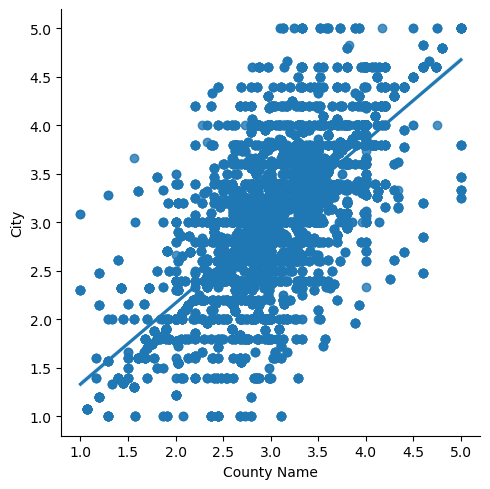

In [25]:
corr_features = correlation(scaled_data, 0.6)
for i in corr_features:
    if (len(i)>1):
        print(i)
sns.lmplot(x="County Name", y="City",  data=data);

City and country name columns are 60% corelated (60% of city data is covered by country name). we can remove either any of it. I am eleminating county name column

In [17]:
scaled_data = scaled_data.drop('County Name', axis = 1)

In [18]:
def Kvalue_(X,random_state = 42, init = 'k-means++',  iteration = 11):
    
    print("Parameters Choosen:\n","Random State: ", random_state, "\n", "Centroid Initial method: ",init)
    
    km_scores= []
    db_score = []
    cl_index = []
    for i in range(2,iteration):
        
        db_scor, cl_inde, km_scor, distb = Euclidean(X, n = i, random_state = random_state, con = 1)
        
        
        km_scores.append(km_scor)    
        db_score.append(db_scor)
        cl_index.append(cl_inde)
        print("\nData Distribution at clusters:",i,"\n","DB Score:",db_scor,"\n","CL Score:",cl_inde)
        print(distb)
    vals = [km_scores, db_score, cl_index]
    indexes = ["WCSS", "DB-Score", "CL score"]
    dict_ind_val = dict(zip(indexes, vals))
    for i in dict_ind_val:
        graphs(dict_ind_val[i],i, range_x = iteration )


In [19]:
def Euclidean(X, n = 9, random_state = 42, init = 'k-means++', con = 0, pickle_file = 'General'):
    global final_centers_Euc
       
    
    km = KMeans(n , random_state = random_state, init=init)
    km.fit(X) 
    preds = km.predict(X)   
    
    inertia = km.inertia_
    final_centers_Euc = km.cluster_centers_
    db_score = davies_bouldin_score(X,preds)
    cl_index = calinski_harabasz_score(X, preds)
   
    if (con == 1):
        return db_score, cl_index, inertia, Counter(preds)
    else:
        return preds    

In [20]:
def graphs(score, name, range_x):
    # The elbow method for determining number of clusters\
    plt.figure(figsize=(5,3))
    plt.title(name+" method for determining number of clusters\n",fontsize=16)
    number_clusters = range(2,range_x)
    plt.plot(number_clusters,score, marker = 'o')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel(name ,fontsize=15)
    plt.xticks([i for i in range(2,range_x)],fontsize=14)
    plt.yticks(fontsize=15)
    # plt.savefig('the_elbow_method.png')
    plt.show()

Parameters Choosen:
 Random State:  42 
 Centroid Initial method:  k-means++

Data Distribution at clusters: 2 
 DB Score: 2.052324564248154 
 CL Score: 1290.0832784446488
Counter({1: 9603, 0: 2005})

Data Distribution at clusters: 3 
 DB Score: 2.235731284577684 
 CL Score: 1396.405835546651
Counter({1: 7226, 2: 2377, 0: 2005})

Data Distribution at clusters: 4 
 DB Score: 1.745325739521551 
 CL Score: 1505.333348035854
Counter({0: 7226, 2: 2005, 1: 1236, 3: 1141})

Data Distribution at clusters: 5 
 DB Score: 2.034700305492154 
 CL Score: 1465.3911583093147
Counter({3: 3799, 1: 3429, 4: 2003, 2: 1236, 0: 1141})

Data Distribution at clusters: 6 
 DB Score: 1.9050760848823136 
 CL Score: 1396.7439067334665
Counter({0: 3348, 2: 3124, 1: 1887, 3: 1160, 5: 1088, 4: 1001})

Data Distribution at clusters: 7 
 DB Score: 1.8118553666725339 
 CL Score: 1329.4724075039712
Counter({0: 2733, 3: 2468, 1: 1889, 2: 1526, 4: 1160, 5: 1088, 6: 744})

Data Distribution at clusters: 8 
 DB Score: 1.742

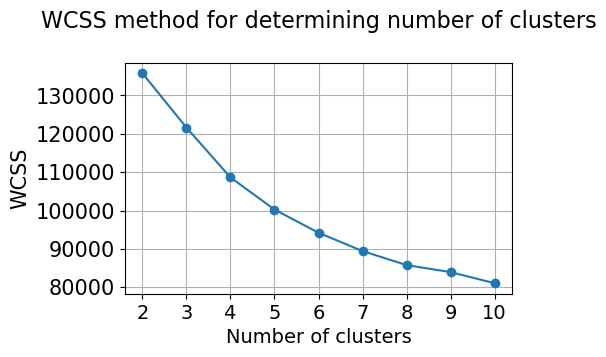

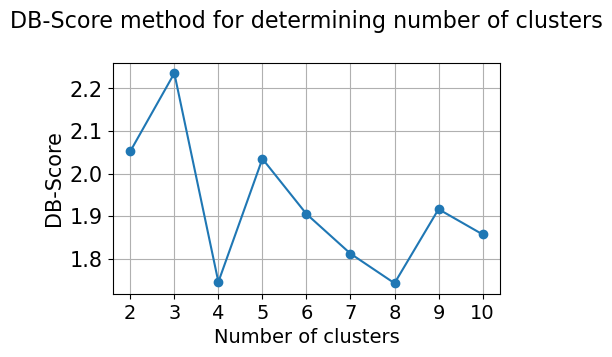

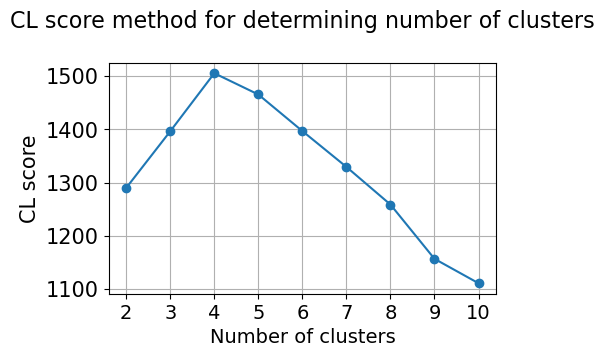

In [21]:
Kvalue_(scaled_data,random_state =42, init = 'k-means++', iteration = 11)

Here we can observe elbow shape at clusters no 4. To validate the number of clusters, we have checked with CL Score and DB Index from that we have observed good number of clusters at 4

In [22]:
preds = Euclidean(scaled_data, n = 4, random_state = 42, init = 'k-means++')

In [23]:
data_copy['Pred_CLuster'] = preds
data_copy.head()

,Facility ID,Facility Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for promoting interoperability of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Year,Pred_CLuster
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,dothan,al,36301,houston,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,below the national average,same as the national average,below the national average,below the national average,same as the national average,same as the national average,same as the national average,2020,0
1,10005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,boaz,al,35957,marshall,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,below the national average,same as the national average,above the national average,same as the national average,same as the national average,above the national average,below the national average,2020,0
2,10006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,florence,al,35630,lauderdale,(256) 768-8400,Acute Care Hospitals,Proprietary,Yes,Y,2,below the national average,same as the national average,above the national average,below the national average,same as the national average,above the national average,below the national average,2020,2
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,opp,al,36467,covington,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,below the national average,same as the national average,below the national average,same as the national average,below the national average,above the national average,same as the national average,2020,0
4,10011,ST. VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,birmingham,al,35235,jefferson,(205) 838-3122,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,2,same as the national average,below the national average,same as the national average,below the national average,below the national average,below the national average,same as the national average,2020,0


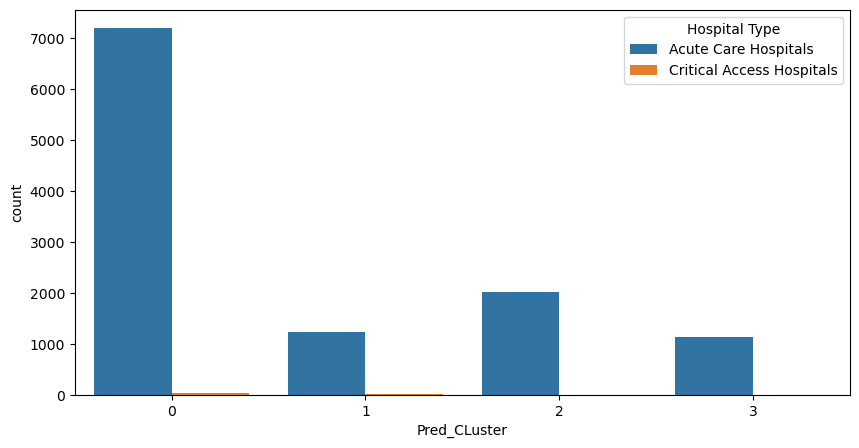

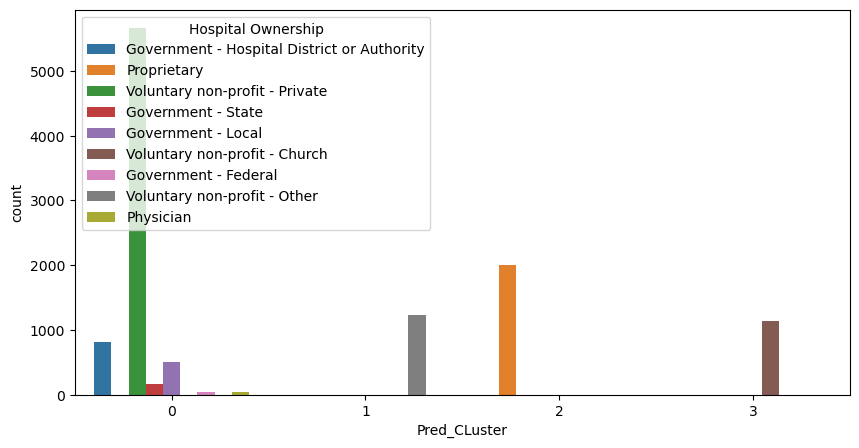

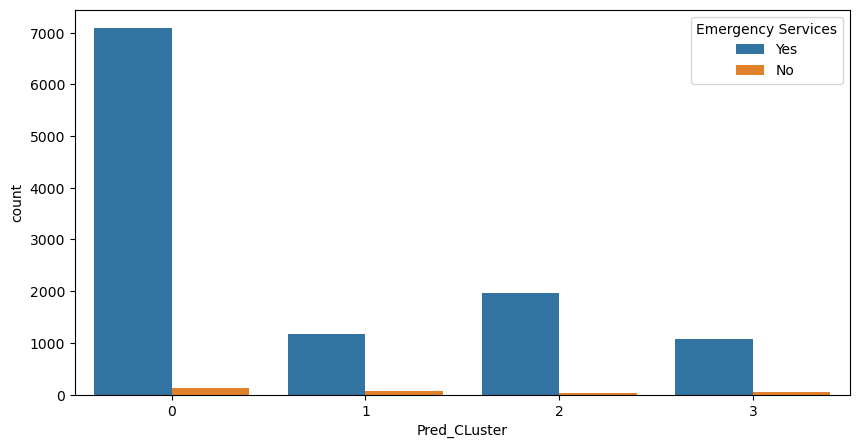

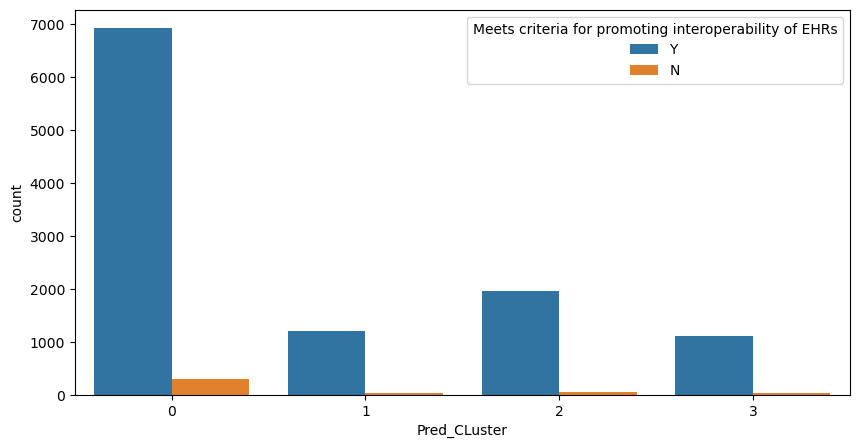

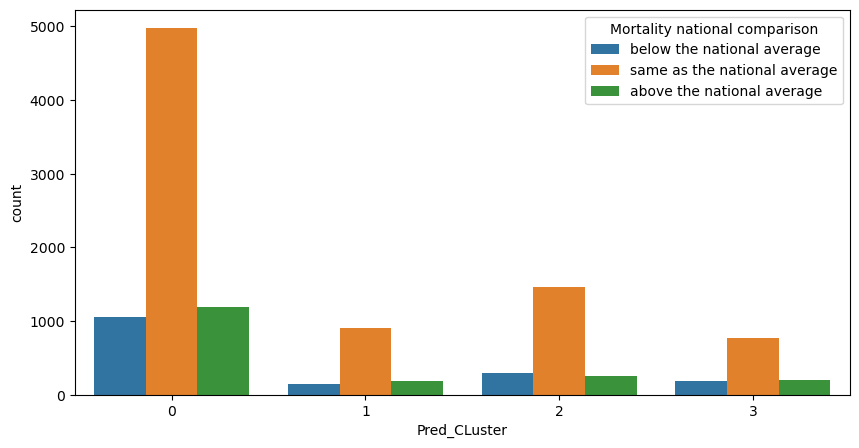

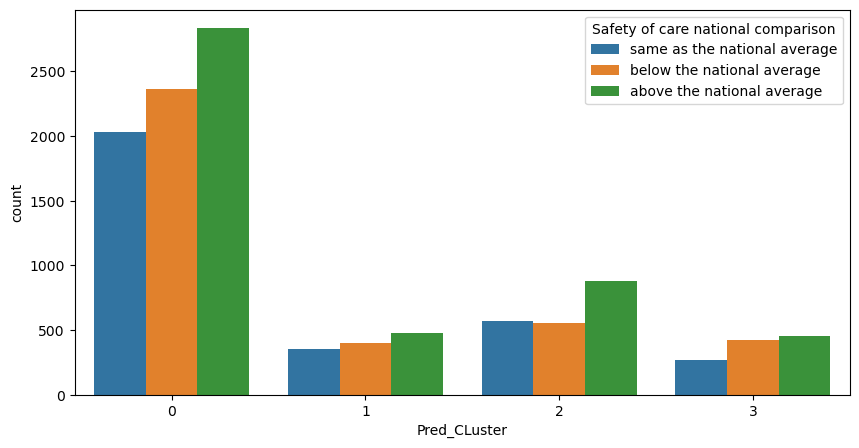

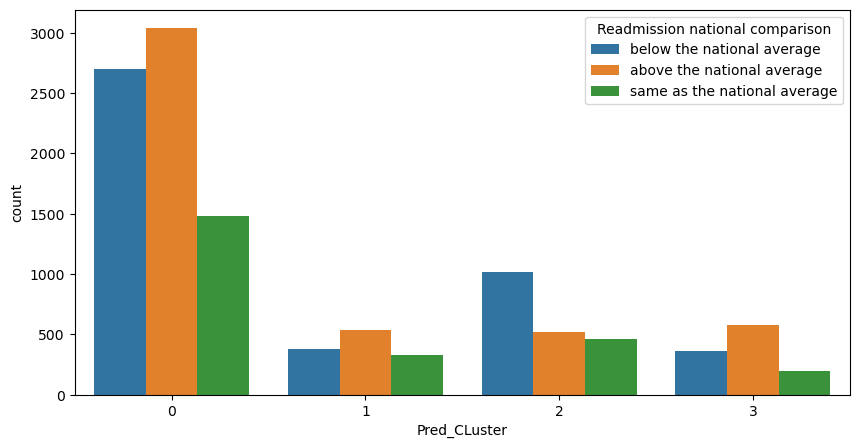

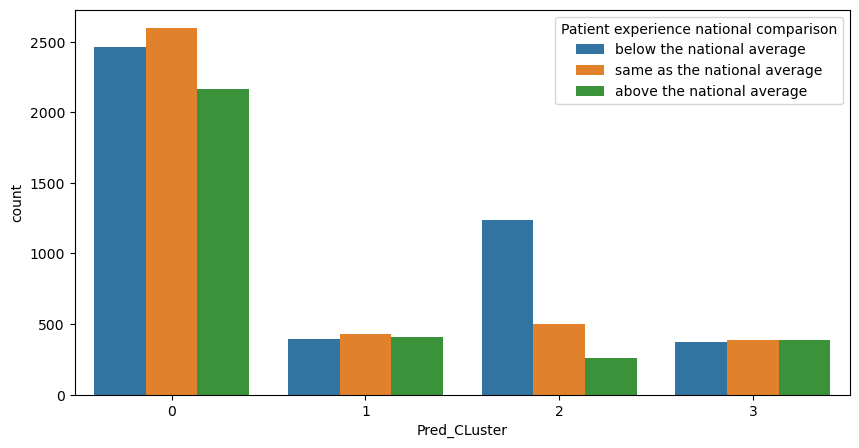

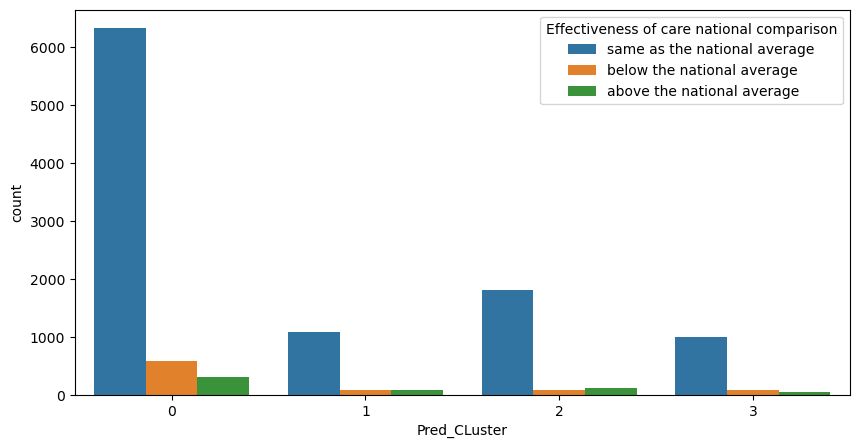

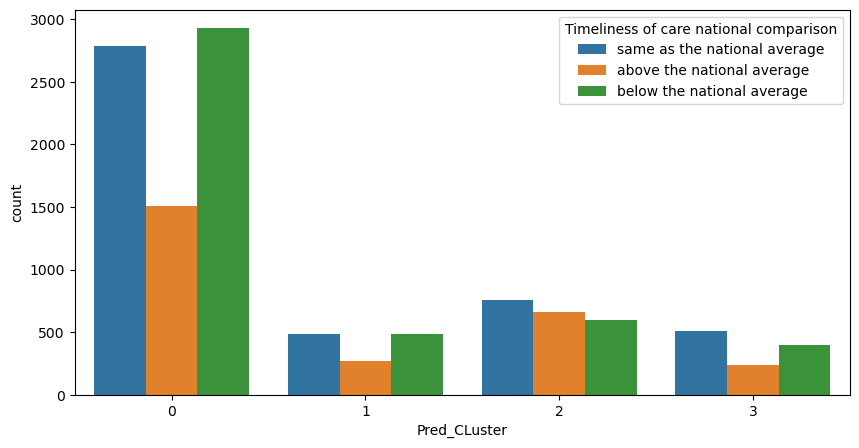

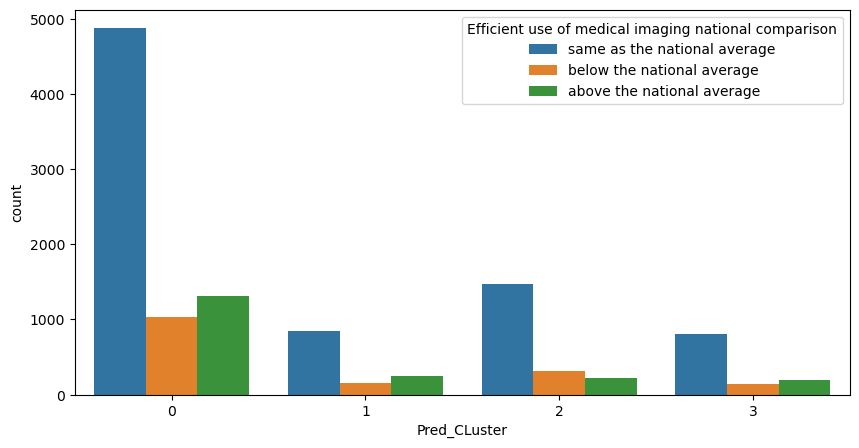

In [24]:
columns_consider = ['Hospital Type', 'Hospital Ownership','Emergency Services',
       'Meets criteria for promoting interoperability of EHRs', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison',]

for col in columns_consider:
    plt.subplots(figsize = (10,5))
    sns.countplot(x='Pred_CLuster',hue=col, data = data_copy)
    plt.show()